<a href="https://colab.research.google.com/github/spour/DeepExplain/blob/master/TFomics_interpretability_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Aug 20 18:16:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install logomaker
!pip install https://github.com/p-koo/tfomics/tarball/master

     |████████████████████████████████| 11.8 MB 110 kB/s 
     \ 19 kB 534 kB/s
  Created wheel for tfomics: filename=tfomics-0.1.0.dev0-py3-none-any.whl size=22510 sha256=e6e5f1135dc639e7dafa7a9f0c3020c9f1629e78d689e9949f9aa34553704b79
  Stored in directory: /tmp/pip-ephem-wheel-cache-o5tp_v8y/wheels/e1/eb/ae/f064df77529927df479c5f666c7572e25493375bcd4c1ff19f
Successfully built tfomics


In [3]:
!wget https://www.dropbox.com/s/5iww0ootxkr6e21/synthetic_code_dataset.h5

--2021-08-20 18:16:40--  https://www.dropbox.com/s/5iww0ootxkr6e21/synthetic_code_dataset.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5iww0ootxkr6e21/synthetic_code_dataset.h5 [following]
--2021-08-20 18:16:41--  https://www.dropbox.com/s/raw/5iww0ootxkr6e21/synthetic_code_dataset.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbbe5f2ba87fe9688620ad98137.dl.dropboxusercontent.com/cd/0/inline/BUlq43MKcaEGzV1CWQbB6-HXyLTf5nE9fCtROqP_cGPyE8YXgYUz_-VDG7bdMvzYLoQ3cTKrY40GDbmhHcBZPMot3spzd022Jk9mcdAj6QiGkZMYEdXUKsCKtEvp6n2AYIC9KY0oaDt0-YUOSy1ffCcl/file# [following]
--2021-08-20 18:16:41--  https://ucbbe5f2ba87fe9688620ad98137.dl.dropboxusercontent.com/cd/0/inline/BUlq43MKcaEGzV1CWQbB6-HXyLTf5nE9fCtROqP_cGPyE8YX

In [4]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

#### Load data

In [24]:
data_path = '.' 
filepath = os.path.join(data_path, 'synthetic_code_dataset.h5')
with h5py.File(filepath, 'r') as dataset:
    x_train = np.array(dataset['X_train']).astype(np.float32)
    y_train = np.array(dataset['Y_train']).astype(np.float32)
    x_valid = np.array(dataset['X_valid']).astype(np.float32)
    y_valid = np.array(dataset['Y_valid']).astype(np.int32)
    x_test = np.array(dataset['X_test']).astype(np.float32)
    y_test = np.array(dataset['Y_test']).astype(np.int32)
    model_test = np.array(dataset['model_test']).astype(np.float32)

model_test = model_test.transpose([0,2,1])
x_train = x_train.transpose([0,2,1])
x_valid = x_valid.transpose([0,2,1])
x_test = x_test.transpose([0,2,1])

N, L, A = x_train.shape
print(model_test.shape)

(4000, 200, 4)


#### Create model

In [6]:
keras.backend.clear_session() 

# l2 regularization
l2 = keras.regularizers.l2(1e-6)

# input layer
inputs = keras.layers.Input(shape=(L,A))

# layer 1 - convolution
nn = keras.layers.Conv1D(filters=32,
                         kernel_size=19,
                         strides=1,
                         activation=None,
                         use_bias=False,
                         padding='same',
                         kernel_regularizer=l2, 
                         )(inputs)        
nn = keras.layers.BatchNormalization()(nn)
nn = keras.layers.Activation('exponential')(nn)
nn = keras.layers.MaxPool1D(pool_size=4)(nn)
nn = keras.layers.Dropout(0.1)(nn)

# layer 2 - convolution
nn = keras.layers.Conv1D(filters=128,
                         kernel_size=7,
                         strides=1,
                         activation=None,
                         use_bias=False,
                         padding='same',
                         kernel_regularizer=l2, 
                         )(nn)        
nn = keras.layers.BatchNormalization()(nn)
nn = keras.layers.Activation('relu')(nn)
nn = keras.layers.MaxPool1D(pool_size=25)(nn)
nn = keras.layers.Dropout(0.1)(nn)

# layer 3 - Fully-connected 
nn = keras.layers.Flatten()(nn)
nn = keras.layers.Dense(512,
                        activation=None,
                        use_bias=False,
                        kernel_regularizer=l2, 
                        )(nn)      
nn = keras.layers.BatchNormalization()(nn)
nn = keras.layers.Activation('relu')(nn)
nn = keras.layers.Dropout(0.5)(nn)

# Output layer
logits = keras.layers.Dense(1, activation='linear', use_bias=True,  
                                kernel_initializer='glorot_normal',
                                bias_initializer='zeros')(nn)
outputs = keras.layers.Activation('sigmoid')(logits)

# create keras model
model = keras.Model(inputs=inputs, outputs=outputs)

# set up optimizer and metrics
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)

# compile model
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
aupr = keras.metrics.AUC(curve='PR', name='aupr')
model.compile(optimizer=optimizer,
                loss=loss,
                metrics=[auroc, aupr])


#### Train model

In [7]:
# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_aupr', #'val_aupr',#
                                            patience=10, 
                                            verbose=1, 
                                            mode='max', 
                                            restore_best_weights=False)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_aupr', 
                                                factor=0.2,
                                                patience=3, 
                                                min_lr=1e-7,
                                                mode='max',
                                                verbose=1) 

# train model
history = model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=128, 
                    shuffle=True,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[es_callback, reduce_lr])


Epoch 1/100
110/110 [==============================] - 33s 21ms/step - loss: 0.6777 - auroc: 0.7098 - aupr: 0.6974 - val_loss: 0.6738 - val_auroc: 0.8184 - val_aupr: 0.8112
Epoch 2/100
110/110 [==============================] - 2s 14ms/step - loss: 0.5118 - auroc: 0.8352 - aupr: 0.8258 - val_loss: 0.6422 - val_auroc: 0.8752 - val_aupr: 0.8726
Epoch 3/100
110/110 [==============================] - 2s 15ms/step - loss: 0.4202 - auroc: 0.8909 - aupr: 0.8841 - val_loss: 0.3924 - val_auroc: 0.9178 - val_aupr: 0.9111
Epoch 4/100
110/110 [==============================] - 2s 14ms/step - loss: 0.3355 - auroc: 0.9312 - aupr: 0.9251 - val_loss: 0.3615 - val_auroc: 0.9487 - val_aupr: 0.9437
Epoch 5/100
110/110 [==============================] - 2s 14ms/step - loss: 0.2824 - auroc: 0.9512 - aupr: 0.9476 - val_loss: 0.2842 - val_auroc: 0.9568 - val_aupr: 0.9501
Epoch 6/100
110/110 [==============================] - 2s 14ms/step - loss: 0.2565 - auroc: 0.9598 - aupr: 0.9569 - val_loss: 0.2588 - val_

#### Evaluate model on test set

In [8]:
# evaluate model on test set
results = model.evaluate(x_test, y_test, batch_size=512, verbose=0)
print(results)

[0.2304457724094391, 0.9765435457229614, 0.9758709073066711]


# Interpretability analysis

#### calculate attribution maps

In [37]:
X_model = model_test[pos_index[:num_analyze]]
print(X_model.shape)

(500, 200, 4)


In [41]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

!pip install simdna
import simdna.synthetic as synthetic
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

nums = np.ones(800)
nums[:100] = 0
np.random.shuffle(nums)


history = model.fit(onehot_data, nums, 
                    epochs=100,
                    batch_size=128, 
                    shuffle=True,
                    validation_split = 0.2, 
                    callbacks=[es_callback, reduce_lr])


Epoch 1/100
5/5 [==============================] - 1s 153ms/step - loss: 1.9828 - auroc: 0.4996 - aupr: 0.8675 - val_loss: 4.9945 - val_auroc: 0.5194 - val_aupr: 0.8882
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 1.8880 - auroc: 0.5175 - aupr: 0.8793 - val_loss: 4.9117 - val_auroc: 0.5246 - val_aupr: 0.8897
Epoch 3/100
5/5 [==============================] - 0s 27ms/step - loss: 1.9455 - auroc: 0.4947 - aupr: 0.8763 - val_loss: 4.8316 - val_auroc: 0.5323 - val_aupr: 0.8909
Epoch 4/100
5/5 [==============================] - 0s 27ms/step - loss: 1.9391 - auroc: 0.4921 - aupr: 0.8695 - val_loss: 4.7453 - val_auroc: 0.5336 - val_aupr: 0.8909
Epoch 5/100
5/5 [==============================] - 0s 27ms/step - loss: 1.9277 - auroc: 0.5189 - aupr: 0.8752 - val_loss: 4.6663 - val_auroc: 0.5370 - val_aupr: 0.8915
Epoch 6/100
5/5 [==============================] - 0s 27ms/step - loss: 1.8987 - auroc: 0.5352 - aupr: 0.8859 - val_loss: 4.5897 - val_auroc: 0.5397 - val_aupr

In [44]:
y_test=y_test[0:800]

In [ ]:
from tfomics import explain

# number of test sequences to analyze (set this to 500 because expintgrad takes long)
num_analyze = 500

# get positive label sequences and sequence model
pos_index = np.where(y_test[:,0] == 1)[0]   
X = onehot_data[pos_index[:num_analyze]]
X_model = np.full((800, 200, 4), 0.25)
# X_model = model_test[pos_index[:num_analyze]]

# instantiate explainer class
explainer = explain.Explainer(model, class_index=0)

# calculate attribution maps
mutagenesis_scores = explainer.mutagenesis(X, class_index=None)
saliency_scores = explainer.saliency_maps(X)
smoothgrad_scores = explainer.smoothgrad(X, num_samples=50, mean=0.0, stddev=0.1)
intgrad_scores = explainer.integrated_grad(X, baseline_type='zeros')
expintgrad_scores = explainer.expected_integrated_grad(X, num_baseline=50, baseline_type='random')

# reduce attribution maps to 1D scores
mut_scores = explain.l2_norm(mutagenesis_scores)
sal_scores = explain.grad_times_input(X, saliency_scores)
sg_scores = explain.grad_times_input(X, smoothgrad_scores)
int_scores = explain.grad_times_input(X, intgrad_scores)
expint_scores = explain.grad_times_input(X, expintgrad_scores)


In [36]:
print(mut_scores.shape)
print(X_model.shape)
print(x_test[:500, :, :].shape)
mutagenesis_roc, mutagenesis_pr = evaluate.interpretability_performance(mut_scores, x_test[:500, :, :], threshold)
mut_scores.shape

(500, 200)
(500, 200, 4)
(500, 200, 4)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


(500, 200)

In [10]:
from tfomics import evaluate

# compare distribution of attribution scores at positions with and without motifs
#I think Xmodel is negative background, e.g. 0.25 for probability of each base in each position
# interpretability_performance(scores, x_model, threshold=0.01)
#     Compare attribution scores to ground truth (e.g. x_model).
#     scores --> (N,L)
#     x_model --> (N,L,A)
threshold = 0.1
mutagenesis_roc, mutagenesis_pr = evaluate.interpretability_performance(mut_scores, X_model, threshold)
saliency_roc, saliency_pr = evaluate.interpretability_performance(sal_scores, X_model, threshold)
smoothgrad_roc, smoothgrad_pr = evaluate.interpretability_performance(sg_scores, X_model, threshold)
intgrad_roc, intgrad_pr = evaluate.interpretability_performance(int_scores, X_model, threshold)
expintgrad_roc, expintgrad_pr = evaluate.interpretability_performance(expint_scores, X_model, threshold)


#### Print interpretabity AUROC 

In [11]:
print("%s: %.3f+/-%.3f"%('mutagenesis', np.mean(mutagenesis_roc), np.std(mutagenesis_roc)))
print("%s: %.3f+/-%.3f"%('saliency', np.mean(saliency_roc), np.std(saliency_roc)))
print("%s: %.3f+/-%.3f"%('smoothgrad', np.mean(smoothgrad_roc), np.std(smoothgrad_roc)))
print("%s: %.3f+/-%.3f"%('intgrad', np.mean(intgrad_roc), np.std(intgrad_roc)))
print("%s: %.3f+/-%.3f"%('expintgrad', np.mean(expintgrad_roc), np.std(expintgrad_roc)))

mutagenesis: 0.899+/-0.067
saliency: 0.864+/-0.059
smoothgrad: 0.867+/-0.056
intgrad: 0.869+/-0.057
expintgrad: 0.869+/-0.058


#### Print interpretabity AUPR

In [12]:
print("%s: %.3f+/-%.3f"%('mutagenesis', np.mean(mutagenesis_pr), np.std(mutagenesis_pr)))
print("%s: %.3f+/-%.3f"%('saliency', np.mean(saliency_pr), np.std(saliency_pr)))
print("%s: %.3f+/-%.3f"%('smoothgrad', np.mean(smoothgrad_pr), np.std(smoothgrad_pr)))
print("%s: %.3f+/-%.3f"%('intgrad', np.mean(intgrad_pr), np.std(intgrad_pr)))
print("%s: %.3f+/-%.3f"%('expintgrad', np.mean(expintgrad_pr), np.std(expintgrad_pr)))


mutagenesis: 0.776+/-0.145
saliency: 0.778+/-0.099
smoothgrad: 0.781+/-0.098
intgrad: 0.786+/-0.097
expintgrad: 0.786+/-0.099


#### Plot interpretability performance box plot

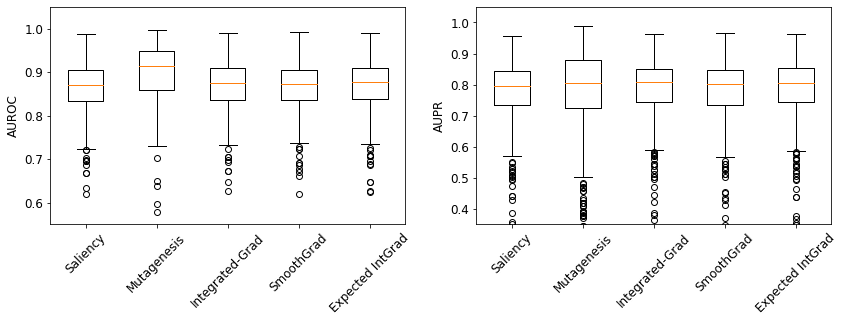

In [13]:
scores = [saliency_roc, mutagenesis_roc, intgrad_roc, smoothgrad_roc, expintgrad_roc]
score_names = ['saliency_scores', 'mut_scores', 'intgrad_scores', 'smoothgrad_scores', 'exp_intgrad_scores']
names = ['Saliency', 'Mutagenesis', 'Integrated-Grad', 'SmoothGrad', 'Expected IntGrad']

fig = plt.figure(figsize=(14,4))  
ax = plt.subplot(1,2,1)
ax.boxplot(scores);
plt.ylabel('AUROC', fontsize=12)
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,6), names, fontsize=12, rotation=45)
ax.set_ybound([.55,1.05])
#ax.tick_params(labelbottom=False) 

scores = [saliency_pr, mutagenesis_pr, intgrad_pr, smoothgrad_pr, expintgrad_pr]
ax = plt.subplot(1,2,2)
ax.boxplot(scores);
plt.ylabel('AUPR', fontsize=12)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
plt.xticks(range(1,6), names, fontsize=12, rotation=45)
ax.set_ybound([.35,1.05])
#ax.tick_params(labelbottom=False) 

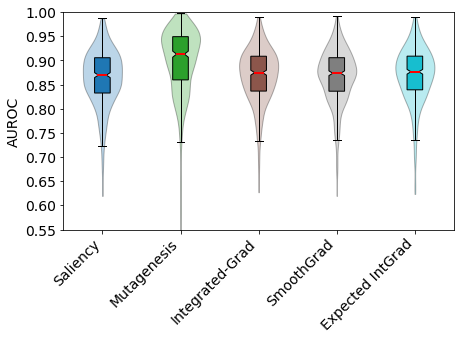

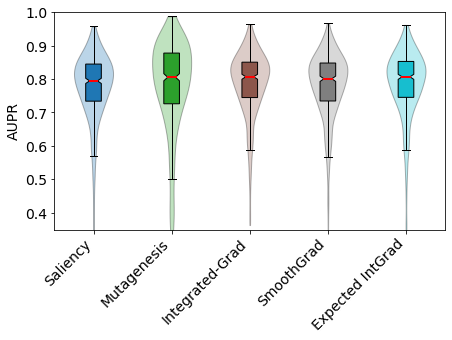

In [14]:
from tfomics import impress

score_names = ['saliency_scores', 'mut_scores', 'intgrad_scores', 'smoothgrad_scores', 'exp_intgrad_scores']
names = ['Saliency', 'Mutagenesis', 'Integrated-Grad', 'SmoothGrad', 'Expected IntGrad']

scores = [saliency_roc, mutagenesis_roc, intgrad_roc, smoothgrad_roc, expintgrad_roc]
fig = plt.figure(figsize=(7,4)) 
ax = impress.box_violin_plot(scores, ylabel='AUROC', xlabel=names)
ax.set_ybound([.55,1.0])
#ax.tick_params(labelbottom=False) 

scores = [saliency_pr, mutagenesis_pr, intgrad_pr, smoothgrad_pr, expintgrad_pr]
fig = plt.figure(figsize=(7,4)) 
ax = impress.box_violin_plot(scores, ylabel='AUPR', xlabel=names)
ax.set_ybound([.35,1.0])
#ax.tick_params(labelbottom=False) 

#### Plot a comparison of the attribution maps


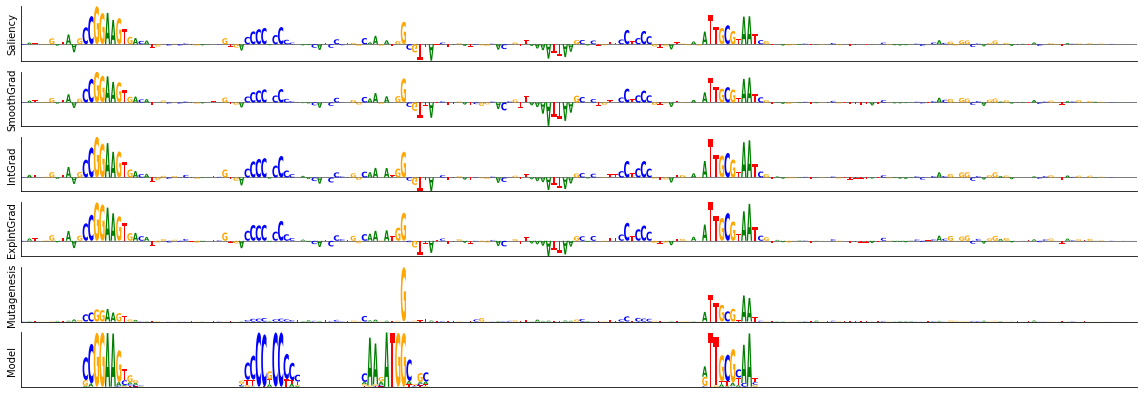

In [15]:
from tfomics import impress

index = 3     # sequence index
x = np.expand_dims(X[index], axis=0)
 
# convert attribution maps to pandas dataframe for logomaker
scores = np.expand_dims(saliency_scores[index], axis=0)
saliency_df = impress.grad_times_input_to_df(x, scores)

scores = np.expand_dims(smoothgrad_scores[index], axis=0)
smoothgrad_df = impress.grad_times_input_to_df(x, scores)

scores = np.expand_dims(intgrad_scores[index], axis=0)
intgrad_df = impress.grad_times_input_to_df(x, scores)

scores = np.expand_dims(expintgrad_scores[index], axis=0)
expintgrad_df = impress.grad_times_input_to_df(x, scores)

scores = np.expand_dims(mutagenesis_scores[index], axis=0)
mutagenesis_df = impress.l2_norm_to_df(x, scores)

# ground truth sequence model
model_df = impress.prob_to_info_df(X_model[index])


# plot comparison
fig = plt.figure(figsize=(20,7))
ax = plt.subplot(6,1,1)
impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
plt.ylabel('Saliency')
ax = plt.subplot(6,1,2)
impress.plot_attribution_map(smoothgrad_df, ax, figsize=(20,1))
plt.ylabel('SmoothGrad')
ax = plt.subplot(6,1,3)
impress.plot_attribution_map(intgrad_df, ax, figsize=(20,1))
plt.ylabel('IntGrad')
ax = plt.subplot(6,1,4)
impress.plot_attribution_map(expintgrad_df, ax, figsize=(20,1))
plt.ylabel('ExpIntGrad')
ax = plt.subplot(6,1,5)
impress.plot_attribution_map(mutagenesis_df, ax, figsize=(20,1))
plt.ylabel('Mutagenesis');
ax = plt.subplot(6,1,6)
impress.plot_attribution_map(model_df, ax, figsize=(20,1))
plt.ylabel('Model');


# Calculate some statistics about signal and noise of attribution scores

In [16]:
from tfomics import evaluate

# compare distribution of attribution scores at positions with and without motifs
threshold = 0.1
top_k = 10
mut_signal, mut_noise_max, mut_noise_mean, mut_noise_topk = evaluate.signal_noise_stats(mut_scores, X_model, top_k, threshold)
sal_signal, sal_noise_max, sal_noise_mean, sal_noise_topk = evaluate.signal_noise_stats(sal_scores, X_model, top_k, threshold)
sg_signal, sg_noise_max, sg_noise_mean, sg_noise_topk = evaluate.signal_noise_stats(sg_scores, X_model, top_k, threshold)
int_signal, int_noise_max, int_noise_mean, int_noise_topk = evaluate.signal_noise_stats(int_scores, X_model, top_k, threshold)
expint_signal, expint_noise_max, expint_noise_mean, expint_noise_topk = evaluate.signal_noise_stats(expint_scores, X_model, top_k, threshold)


# Plot signal to noise ratio of attribution scores

Signal is determined by position with the motif and the noise is set to the max attribution score where motifs are not embedded


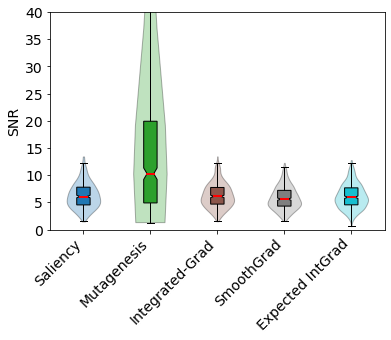

In [17]:
from tfomics import impress 

scores = [sal_signal/sal_noise_mean, 
          mut_signal/mut_noise_mean,
          int_signal/int_noise_mean,
          sg_signal/sg_noise_mean,
          expint_signal/expint_noise_mean]
names = ['Saliency', 'Mutagenesis', 'Integrated-Grad', 'SmoothGrad', 'Expected IntGrad']

fig = plt.figure(figsize=(6,4))
ax = impress.box_violin_plot(scores, ylabel='SNR', xlabel=names)
ax.set_ybound([0, 40])


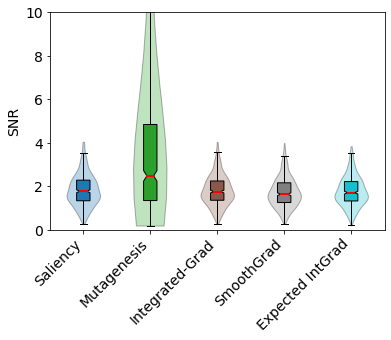

In [18]:
scores = [sal_signal/sal_noise_topk, 
          mut_signal/mut_noise_topk,
          int_signal/int_noise_topk,
          sg_signal/sg_noise_topk,
          expint_signal/expint_noise_topk]
names = ['Saliency', 'Mutagenesis', 'Integrated-Grad', 'SmoothGrad', 'Expected IntGrad']

fig = plt.figure(figsize=(6,4))
ax = impress.box_violin_plot(scores, ylabel='SNR', xlabel=names)
ax.set_ybound([0, 10])


# Plot average signal and top-k noise of attribution maps

Signal and noise are determined by positions with motifs and without motifs

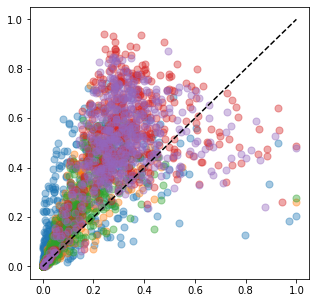

In [19]:
fig = plt.figure(figsize=(5,5))
norm = np.max([mut_signal, mut_noise_topk])
plt.scatter(mut_noise_topk/norm, mut_signal/norm, s=50, alpha=0.4)
norm = np.max([sal_signal, sal_noise_topk])
plt.scatter(sal_noise_topk/norm, sal_signal/norm, s=50, alpha=0.4)
norm = np.max([sg_signal, sg_noise_topk])
plt.scatter(sg_noise_topk/norm, sg_signal/norm, s=50, alpha=0.4)
norm = np.max([int_signal, int_noise_topk])
plt.scatter(int_noise_topk/norm, int_signal/norm, s=50, alpha=0.4)
norm = np.max([expint_signal, expint_noise_topk])
plt.scatter(expint_noise_topk/norm, expint_signal/norm, s=50, alpha=0.4)
plt.plot([0,1], [0,1], '--k')